In [50]:
import numpy as np 
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
import datetime
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [51]:
import warnings
warnings.filterwarnings("ignore")

In [52]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv')

In [53]:
import kagglehub

path = kagglehub.dataset_download("uciml/faulty-steel-plates")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/faulty-steel-plates


In [54]:
cheat_df = pd.read_csv('/kaggle/input/faulty-steel-plates/faults.csv')

In [55]:
train_df = pd.concat([train_df, cheat_df])

# Предобработка

Посмотрим на данные

In [56]:
train_df.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0.0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1.0,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2.0,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3.0,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4.0,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [57]:
train_df.describe()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,19219.000000,21160.000000,21160.000000,2.116000e+04,2.116000e+04,21160.000000,21160.000000,21160.000000,2.116000e+04,21160.000000,...,21160.000000,21160.000000,21160.000000,21160.000000,21160.000000,21160.000000,21160.000000,21160.000000,21160.000000,21160.000000
mean,9609.000000,697.130057,741.392202,1.831495e+06,1.828639e+06,1703.240832,97.140737,65.852457,1.931736e+05,84.784594,...,0.100958,-0.137733,0.573142,0.076749,0.063327,0.180671,0.030246,0.025520,0.244093,0.341730
std,5548.191747,532.054574,501.160090,1.892922e+06,1.886266e+06,3884.800851,192.510008,161.187566,4.489348e+05,29.121342,...,0.488925,0.123237,0.332903,0.266198,0.243556,0.384755,0.171267,0.157701,0.429558,0.474301
min,0.000000,0.000000,4.000000,6.712000e+03,6.724000e+03,2.000000,2.000000,1.000000,2.500000e+02,0.000000,...,-0.991000,-0.998900,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4804.500000,50.000000,214.000000,6.394900e+05,6.395070e+05,88.000000,15.000000,14.000000,9.778000e+03,68.000000,...,-0.272700,-0.192600,0.253200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9609.000000,754.000000,772.000000,1.378585e+06,1.378261e+06,169.000000,25.000000,24.000000,1.840200e+04,90.000000,...,0.111100,-0.142600,0.472900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14413.500000,1145.000000,1161.000000,2.339627e+06,2.336466e+06,659.000000,67.000000,62.000000,6.841600e+04,105.000000,...,0.526300,-0.082800,0.999400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,19218.000000,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,...,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21160 entries, 0 to 1940
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     19219 non-null  float64
 1   X_Minimum              21160 non-null  int64  
 2   X_Maximum              21160 non-null  int64  
 3   Y_Minimum              21160 non-null  int64  
 4   Y_Maximum              21160 non-null  int64  
 5   Pixels_Areas           21160 non-null  int64  
 6   X_Perimeter            21160 non-null  int64  
 7   Y_Perimeter            21160 non-null  int64  
 8   Sum_of_Luminosity      21160 non-null  int64  
 9   Minimum_of_Luminosity  21160 non-null  int64  
 10  Maximum_of_Luminosity  21160 non-null  int64  
 11  Length_of_Conveyer     21160 non-null  int64  
 12  TypeOfSteel_A300       21160 non-null  int64  
 13  TypeOfSteel_A400       21160 non-null  int64  
 14  Steel_Plate_Thickness  21160 non-null  int64  
 15  Edges_In

У нас 27 численных признаков и мультиклассовая классификация (7 классов)

In [59]:
target_features = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains','Dirtiness', 'Bumps', 'Other_Faults']
train_df = train_df[train_df[target_features].sum(axis=1) <= 1]
train_df['Outside_Global_Index'] = np.where(train_df['Outside_Global_Index']==0.7, 0.5, train_df['Outside_Global_Index'])

In [60]:
id_train = train_df['id']
id_test = test_df['id']
train_df.drop(columns='id',inplace=True)
test_df.drop(columns='id',inplace=True)

Разобьем тренировочный датасет на матрицу признаков и таргет

In [61]:
target_columns = [column for column in train_df.columns if column not in test_df.columns]
print("Целевые признаки:", target_columns)

Целевые признаки: ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']


In [62]:
X_train = train_df[test_df.columns]
y_train = train_df[target_columns]
X_test = test_df.copy()

Проверим, какие из признаков являются категориальными

In [63]:
for column_name in X_train.columns:
    print(f"Number of unique values in {column_name} column:", X_train[column_name].nunique())

Number of unique values in X_Minimum column: 1218
Number of unique values in X_Maximum column: 1272
Number of unique values in Y_Minimum column: 3458
Number of unique values in Y_Maximum column: 3447
Number of unique values in Pixels_Areas column: 1158
Number of unique values in X_Perimeter column: 470
Number of unique values in Y_Perimeter column: 337
Number of unique values in Sum_of_Luminosity column: 2615
Number of unique values in Minimum_of_Luminosity column: 165
Number of unique values in Maximum_of_Luminosity column: 104
Number of unique values in Length_of_Conveyer column: 100
Number of unique values in TypeOfSteel_A300 column: 2
Number of unique values in TypeOfSteel_A400 column: 2
Number of unique values in Steel_Plate_Thickness column: 27
Number of unique values in Edges_Index column: 1876
Number of unique values in Empty_Index column: 1773
Number of unique values in Square_Index column: 1135
Number of unique values in Outside_X_Index column: 530
Number of unique values in 

Судя по числу уникальных значений, три признака являются категориальными. Разделим категориальные и численные признаки

In [64]:
categorical_features = ['TypeOfSteel_A300', 'TypeOfSteel_A400']
numerical_features = [f for f in X_train.columns if f not in categorical_features]

Посмотрим на распределение численных признаков

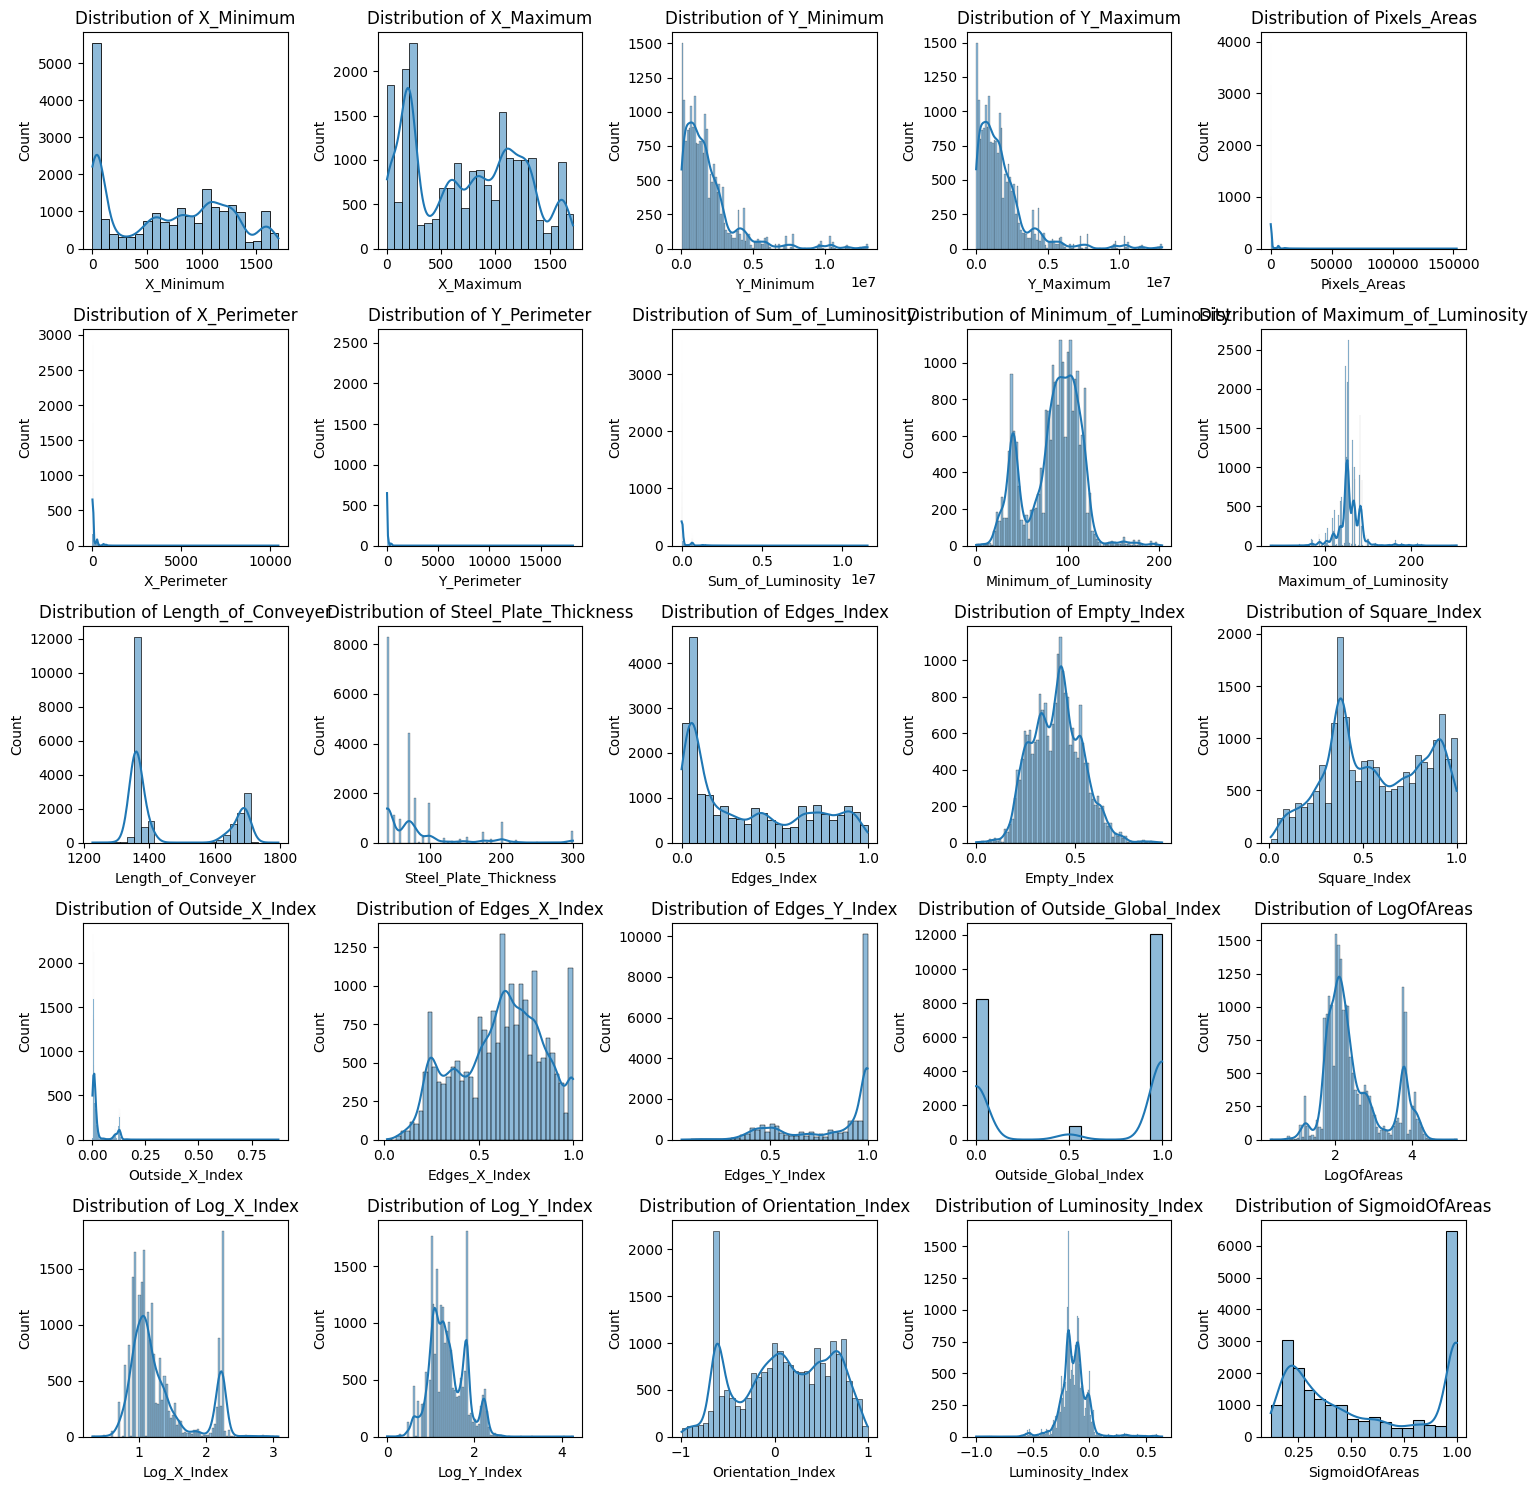

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

num_features = len(numerical_features)

n_cols = 5
n_rows = math.ceil(num_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))

axes = axes.flatten()

for idx, col in enumerate(numerical_features):
    sns.histplot(X_train[col], kde=True, ax=axes[idx])
    axes[idx].set_title(f"Distribution of {col}")

for idx in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

Преобразуем категориальные признаки, используя One Hot Encoding. Для численных признаков применим Robust Scaler (так как, судя по графикам, присутствуют выбросы)

In [66]:
'''preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse=False), categorical_features),
        ('num', RobustScaler(), numerical_features)
    ],
    remainder='passthrough'
)

X_train_encoded = preprocessor.fit_transform(X_train)
new_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(new_feature_names) + list(X_train.drop(columns=categorical_features).columns)
X_train_encoded = pd.DataFrame(X_train_encoded, columns=all_feature_names)'''

"preprocessor = ColumnTransformer(\n    transformers=[\n        ('cat', OneHotEncoder(drop='first', sparse=False), categorical_features),\n        ('num', RobustScaler(), numerical_features)\n    ],\n    remainder='passthrough'\n)\n\nX_train_encoded = preprocessor.fit_transform(X_train)\nnew_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)\nall_feature_names = list(new_feature_names) + list(X_train.drop(columns=categorical_features).columns)\nX_train_encoded = pd.DataFrame(X_train_encoded, columns=all_feature_names)"

In [67]:
X_train_encoded = X_train

# Baseline

В качестве бейзлайна возьмем градиентный бустинг

In [68]:
from sklearn.ensemble import GradientBoostingClassifier

In [69]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_encoded, y_train, test_size=0.2, random_state=42)
y_tr_labels = np.argmax(y_tr, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

In [70]:
'''X_test_encoded = preprocessor.transform(X_test)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=all_feature_names)'''

X_test_encoded = X_test

In [ ]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.2,
                                 max_depth=3, random_state=0).fit(X_tr, y_tr_labels)

In [ ]:
from sklearn.metrics import roc_auc_score

#print(roc_auc_score(y_val, clf.predict_proba(X_val), multi_class='ovr'))

In [ ]:
y_labels = np.argmax(y_train, axis=1)
clf_full_trained = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                 max_depth=3, random_state=0).fit(X_train_encoded, y_labels)

In [ ]:
predicted_probs = clf_full_trained.predict_proba(X_test_encoded)

In [ ]:
predicted_probs_df = pd.DataFrame(predicted_probs, columns=target_columns)
predicted_probs_df['id'] = id_test
cols = predicted_probs_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
predicted_probs_df = predicted_probs_df[cols]

In [ ]:
predicted_probs_df.to_csv('submission.csv', index=False)

# Baseline upgrade

In [71]:
X_train_encoded['Ratio_Length_Thickness'] = X_train_encoded['Length_of_Conveyer'] / (X_train_encoded['Steel_Plate_Thickness'] + 0.001) 
X_train_encoded['Normalized_Steel_Thickness'] = (X_train_encoded['Steel_Plate_Thickness'] - X_train_encoded['Steel_Plate_Thickness'].min()) / (X_train_encoded['Steel_Plate_Thickness'].max() - X_train_encoded['Steel_Plate_Thickness'].min())
X_train_encoded['X_Range*Pixels_Areas'] = (X_train_encoded['X_Maximum'] - X_train_encoded['X_Minimum']) * X_train_encoded['Pixels_Areas']
X_train_encoded['Y_Range*Pixels_Areas'] = (X_train_encoded['Y_Maximum'] - X_train_encoded['Y_Minimum']) * X_train_encoded['Pixels_Areas']

X_test_encoded['Ratio_Length_Thickness'] = X_test_encoded['Length_of_Conveyer'] / (X_test_encoded['Steel_Plate_Thickness'] + 0.001)
X_test_encoded['Normalized_Steel_Thickness'] = (X_test_encoded['Steel_Plate_Thickness'] - X_test_encoded['Steel_Plate_Thickness'].min()) / (X_test_encoded['Steel_Plate_Thickness'].max() - X_test_encoded['Steel_Plate_Thickness'].min())
X_test_encoded['X_Range*Pixels_Areas'] = (X_test_encoded['X_Maximum'] - X_test_encoded['X_Minimum']) * X_test_encoded['Pixels_Areas']
X_test_encoded['Y_Range*Pixels_Areas'] = (X_test_encoded['Y_Maximum'] - X_test_encoded['Y_Minimum']) * X_test_encoded['Pixels_Areas']

In [72]:
features_to_drop = ['Y_Minimum', 'Steel_Plate_Thickness', 'Sum_of_Luminosity', 'Edges_X_Index', 'SigmoidOfAreas', 'Luminosity_Index']
X_train_encoded = X_train_encoded.drop(features_to_drop,axis = 1)
X_test_encoded = X_test_encoded.drop(features_to_drop,axis = 1)

In [73]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_encoded, y_train, test_size=0.1, random_state=42)
y_tr_labels = np.argmax(y_tr, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

In [ ]:
stacking_clf = stacking_clf.fit(X_tr, y_tr_labels)

In [ ]:
print(roc_auc_score(y_val, stacking_clf.predict_proba(X_val), multi_class='ovr'))

In [74]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


In [75]:
train_pool = Pool(data=X_tr, label=y_tr_labels)
valid_pool = Pool(data=X_val, label=y_val_labels)

In [45]:
lgbm_params = {
    "objective": "multiclass",
    'num_class': 8,
    "boosting_type": "gbdt",
    "verbosity": -1,
    "early_stopping_rounds": 50,
    'n_estimators': 3000,
    'learning_rate': 0.00711725041768046,
    'lambda_l1': 0.00440985033109004,
    'lambda_l2': 1.0606279361419868e-08,
    'max_depth': 8,
    'colsample_bytree': 0.33443191322905963,
    'subsample': 0.6551114943335209,
    'min_child_weight': 1,
    'num_leaves': 1019,
    'min_child_samples': 94,
}

cat_params = {
    "loss_function": "MultiClass",
    "eval_metric": "MultiClass",
    "bootstrap_type": "Bernoulli",
    "early_stopping_rounds": 100,
    "verbose": False,
    'n_estimators': 2000,
    'learning_rate': 0.018384945397206656,
    'l2_leaf_reg': 0.8746200477430335,
    'depth': 6,
    'colsample_bylevel': 0.1250483657354198,
    'subsample': 0.8794673581253512

}
    
hgbc_params = {
    'learning_rate': 0.038914759891422,
    'max_iter': 1381,
    'max_depth': 4,
    'l2_regularization': 9.698385966882728e-07,
    'min_samples_leaf': 281,
    'max_bins': 100
}

xgb_params = {
    'grow_policy': 'depthwise',
    'multi_strategy': 'multi_output_tree',
    'n_estimators': 3000,
    'early_stopping_rounds': 50,
    'learning_rate': 0.011991933688453596,
    'gamma': 0.037522403671044376,
    'subsample': 0.8810951837647127,
    'colsample_bytree': 0.36803100807865063,
    'max_depth': 6,
    'min_child_weight': 2,
    'lambda': 0.38010636016035176,
    'alpha': 0.047233571811149226,
}

gb_params = {
    'n_estimators': 500,
    'learning_rate': 0.11991933688453596,
    'subsample': 0.8810951837647127,
    'max_depth': 6
}

In [46]:
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [28]:
'''X_test_encoded['Normalized_Steel_Thickness'] = (X_test_encoded['Steel_Plate_Thickness'] - X_test_encoded['Steel_Plate_Thickness'].min()) / (X_test_encoded['Steel_Plate_Thickness'].max() - X_test_encoded['Steel_Plate_Thickness'].min())
X_test_encoded['X_Range*Pixels_Areas'] = (X_test_encoded['X_Maximum'] - X_test_encoded['X_Minimum']) * X_test_encoded['Pixels_Areas']
X_test_encoded = X_test_encoded.drop(features_to_drop,axis = 1)'''

In [76]:
model = CatBoostClassifier(**cat_params)

model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50)

In [77]:
print(roc_auc_score(y_val, model.predict_proba(X_val), multi_class='ovr'))

0.8967949192051591


In [78]:
lgbm = LGBMClassifier(**lgbm_params)
lgbm.fit(
        X_tr, y_tr_labels,
        eval_set=[(X_val, y_val_labels)]
    )
meta_pred_2 = lgbm.predict_proba(X_val)
print(roc_auc_score(y_val, lgbm.predict_proba(X_val), multi_class='ovr'))

0.8961637581080583


In [79]:
hgbc = HistGradientBoostingClassifier(**hgbc_params).fit(X_train_encoded,  np.argmax(y_train, axis=1))
print(roc_auc_score(y_val, hgbc.predict_proba(X_val), multi_class='ovr'))

0.9177442418997969


In [80]:
xgb = XGBClassifier(**xgb_params)
xgb.fit(X_tr, y_tr_labels, eval_set=[(X_val, y_val_labels)], verbose=0)
print(roc_auc_score(y_val, xgb.predict_proba(X_val), multi_class='ovr'))

0.89769449550529


In [99]:
from sklearn.ensemble import GradientBoostingClassifier
xgb_model = GradientBoostingClassifier()
xgb_model.fit(X_tr, y_tr_labels)
print(roc_auc_score(y_val, xgb_model.predict_proba(X_val), multi_class='ovr'))

0.8924511290988443


In [98]:
rf_model = RandomForestClassifier(n_estimators=2000)
rf_model.fit(X_tr, y_tr_labels)
print(roc_auc_score(y_val, rf_model.predict_proba(X_val), multi_class='ovr'))

0.8922017763642943


In [111]:
score_1 = roc_auc_score(y_val, model.predict_proba(X_val), multi_class='ovr')
score_2 = roc_auc_score(y_val, hgbc.predict_proba(X_val), multi_class='ovr')
score_3 = roc_auc_score(y_val, lgbm.predict_proba(X_val), multi_class='ovr')
score_4 = roc_auc_score(y_val, xgb.predict_proba(X_val), multi_class='ovr')
score_5 = roc_auc_score(y_val, xgb_model.predict_proba(X_val), multi_class='ovr')
sum_score = score_1 + score_2 + score_3 + score_4 + score_5
coef_1, coef_2, coef_3, coef_4, coef_5 = score_1 / sum_score, score_2 / sum_score, score_3 / sum_score, score_4 / sum_score, score_5 / sum_score

In [112]:
coef_1, coef_2, coef_3, coef_4, coef_5

(0.20571996201768825,
 0.20085988776755115,
 0.19613672704969687,
 0.1964717482111188,
 0.20081167495394495)

In [113]:
predicted_probs_1 = hgbc.predict_proba(X_test_encoded)
model.fit(X_train_encoded,  np.argmax(y_train, axis=1))
predicted_probs_2 = model.predict_proba(X_test_encoded)
predicted_probs_3 = lgbm.predict_proba(X_test_encoded)
xgb_model.fit(X_train_encoded, np.argmax(y_train, axis=1))
predicted_probs_5 = xgb_model.predict_proba(X_test_encoded)

predicted_probs_4 = xgb.predict_proba(X_test_encoded)
predicted_probs_df = pd.DataFrame((coef_5 * predicted_probs_5 + coef_4 * predicted_probs_4 + coef_3 * predicted_probs_3 + coef_2 * predicted_probs_1 + coef_1 * predicted_probs_2)/5, columns=target_columns)
predicted_probs_df['id'] = id_test
cols = predicted_probs_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
predicted_probs_df = predicted_probs_df[cols]

In [115]:
predicted_probs_df.to_csv('submission.csv', index=False)